In this notebook, we demo two features of SNAPHU:

1. Unwrapping using the "tiling" mode, where the scene is broken up into tiles, each unwrapped separately (and in parallel), with a final stitching adjustment
2. Using the "unwrapped" mode, where you start with something (mostly) unwrapped, and run a final reoptimization
  - This will be used on the output of the low-resolution-guided unwrapping 

# Example data: Napa 2014 Earthquake

https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_23511_14068-001_14128-002_0092d_s01_L090_02#data

UAVSAR flight line 23511, repeat pass interferometry (RPI) data product produced by UAVSAR.

We'll download the wrapped interferogram, crop it slightly, then unwrap it.

In [1]:
import os
import subprocess
import numpy as np

# CHANGE ME! Wherever you plan on storing the data for analysis
WORKDIR = "/data6/scott/jpl/sanAnd/rpi/test-tile"

os.chdir(WORKDIR)
print(os.getcwd())

/data6/scott/jpl/sanAnd/rpi/test-tile


In [9]:
url_ann = "http://uavsar.asfdaac.alaska.edu/UA_SanAnd_23511_14068-001_14128-002_0092d_s01_L090_02/SanAnd_23511_14068-001_14128-002_0092d_s01_L090HH_02.ann"
url_ifg = "http://uavsar.asfdaac.alaska.edu/UA_SanAnd_23511_14068-001_14128-002_0092d_s01_L090_02/SanAnd_23511_14068-001_14128-002_0092d_s01_L090HH_02.int"
url_cor = "http://uavsar.asfdaac.alaska.edu/UA_SanAnd_23511_14068-001_14128-002_0092d_s01_L090_02/SanAnd_23511_14068-001_14128-002_0092d_s01_L090HH_02.cor"

ifg_filename = url_ifg.split("/")[-1]
cor_filename = url_cor.split("/")[-1]

In [3]:
# Download the interferogram, along with the annotation and correlation files
for url in [url_ifg, url_ann, url_cor]:
    cmd = "wget --no-clobber {url}".format(url=url)
    print(cmd)
    subprocess.check_call(cmd, shell=True)

wget --no-clobber http://uavsar.asfdaac.alaska.edu/UA_SanAnd_23511_14068-001_14128-002_0092d_s01_L090_02/SanAnd_23511_14068-001_14128-002_0092d_s01_L090HH_02.int
wget --no-clobber http://uavsar.asfdaac.alaska.edu/UA_SanAnd_23511_14068-001_14128-002_0092d_s01_L090_02/SanAnd_23511_14068-001_14128-002_0092d_s01_L090HH_02.ann
wget --no-clobber http://uavsar.asfdaac.alaska.edu/UA_SanAnd_23511_14068-001_14128-002_0092d_s01_L090_02/SanAnd_23511_14068-001_14128-002_0092d_s01_L090HH_02.cor


Lets see what this interferogram looks like to crop only the interesting part.

(Note: this is using my grab-bag-package of utility functions, `apertools`, to plot the interferograms. It can be installed with `pip install apertools` or downloaded from https://github.com/scottstanie/apertools, but you can skip these plotting parts if you'd rather not)

In [ ]:
# If plotting functions are desired, uncomment next line
# !python -m pip install apertools

In [10]:
from apertools import plotting
import matplotlib.pyplot as plt

%matplotlib inline

In [11]:
ifg_full = np.fromfile(ifg_filename, dtype="complex64").reshape((-1, 3300))
cor_full = np.fromfile(cor_filename, dtype="float32").reshape((-1, 3300))
print(ifg_full.shape, ifg_full.dtype)
print(cor_full.shape, cor_full.dtype)

(12722, 3300) complex64
(12722, 3300) float32


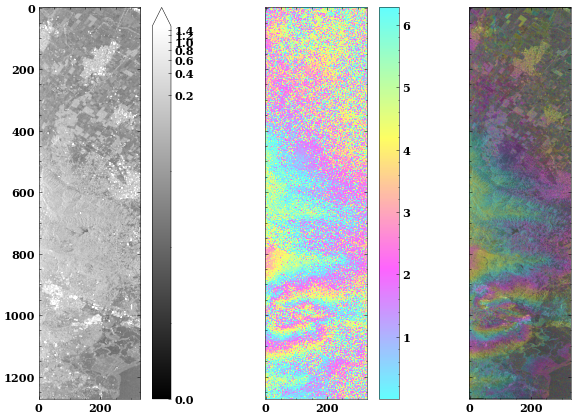

In [32]:
# skip every 10 pixels since these are huge images
plotting.plot_ifg(ifg_full[::10, ::10], figsize=(10, 6), expval=.1);

The earthquake rupture is in the bottom of the interferogram. We'll keep lines 8000-12000 around it

In [12]:
min_line, max_line = 8000, 12000
ifg_cropped = ifg_full[min_line:max_line]
cor_cropped = cor_full[min_line:max_line]

ifg_cropped_filename = "cropped_" + ifg_filename
cor_cropped_filename = "cropped_" + cor_filename

rows, cols = ifg_cropped.shape
print(ifg_cropped.shape)

(4000, 3300)


In [13]:
# Save these cropped versions for snaphu
ifg_cropped.tofile(ifg_cropped_filename)
cor_cropped.tofile(cor_cropped_filename)

In [25]:
!ls

cropped_SanAnd_23511_14068-001_14128-002_0092d_s01_L090HH_02.cor
cropped_SanAnd_23511_14068-001_14128-002_0092d_s01_L090HH_02.int
SanAnd_23511_14068-001_14128-002_0092d_s01_L090HH_02.ann
SanAnd_23511_14068-001_14128-002_0092d_s01_L090HH_02.cor
SanAnd_23511_14068-001_14128-002_0092d_s01_L090HH_02.int


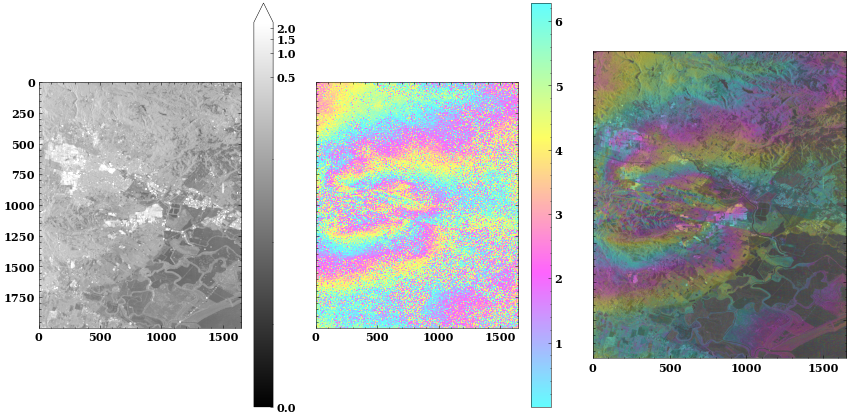

In [31]:
plotting.plot_ifg(ifg_cropped[::2, ::2], figsize=(12, 6), expval=.1);

# Unwrapping with SNAPHU's tile mode

In this mode, the large image is broken up into overlapping rectangles. Each one can be unwrapped in parallel, resulting in a much faster unwrapping compared to a single tile (which can only run on a single process).

You can specify
- The number of the tiles to break the image into
- The overlap in the row/column direction
  - From these two parameters, it will calculate the size of the tiles for you
- The number of processes to use for unwrapping in parallel




<div class="alert alert-info">
<b>Note on overlap size:</b> If you choose a tile overlap which is too small, you have a chance of getting artifacts on the edge of tiles. These may show up as horizontal or vertical lines through the unwrapped phase.

</div>


**Rule of thumb**: use overlaps >= 400.


## Configuring tile mode
You can specify this via the command line call to `snaphu` or using a configuration file (shown later).

Relevant command line options:

> −−tile: ntilerow ntilecol rowovrlp colovrlp 

> −−nproc n: Use n parallel processes when in tile mode. 

> −S:  Do single-tile re-optimization after tile-mode initialization.


**Note on "deformation mode" vs "smooth mode"**:

> -s: Run in smooth-solution mode. The problem statistics and resulting cost functions are based on the assumption that the true unwrapped phase represents a generic surface with no discontinuities. **This is the same as deformation mode with the DEFOMAX parameter set to zero.**

Source from from [Snaphu man page](https://web.stanford.edu/group/radar/softwareandlinks/sw/snaphu/snaphu_man1.html#OPTIONS) 



Since you can't specify the file formats via command line options; therefore, **we need to make a configuration file** for UAVSAR's correlation data (which is only float data, as opposed to the `ALT_LINE_DATA` that snaphu assumes).

In [15]:
# Examples of config files take from https://web.stanford.edu/group/radar/softwareandlinks/sw/snaphu/snaphu.conf.full

conf_template = """
# snaphu configuration file

# Input file name
INFILE       {infile}
INFILEFORMAT        {informat}

# Input file line length
LINELENGTH    {width}


# Output file
OUTFILE             {outfile}
OUTFILEFORMAT       {outformat}

# Correlation file
CORRFILE     {corfile}
CORRFILEFORMAT      FLOAT_DATA

STATCOSTMODE SMOOTH

INITMETHOD    MCF

################
# Tile control #
################

# Parameters in this section describe how the input files will be 
# tiled.  This is mainly used for tiling, in which different
# patches of the interferogram are unwrapped separately.

# Number of rows and columns of tiles into which the data files are
# to be broken up.
NTILEROW		{ntilerow}
NTILECOL		{ntilecol}

# Overlap, in pixels, between neighboring tiles.
# Using the same overlap for rows and cols here, but they can be different in general
ROWOVRLP		{overlap}
COLOVRLP		{overlap}

# Maximum number of child processes to start for parallel tile
# unwrapping.
NPROC			{nproc}
"""

outfile1 = ifg_cropped_filename.replace(".int", "_tiled.unw")
# specify the number of row tiles and column tiles (9 total)
ntilerow, ntilecol = 3, 3
# Use 1 CPU process per tile
nproc = ntilerow * ntilecol
# overlap each tile by 400 pixels to help avoid across-tile artifacts
overlap = 400

conf = "snaphu_tiling.conf"
with open(conf, "w") as f:
    f.write(
        conf_template.format(
            infile=ifg_cropped_filename,
            corfile=cor_cropped_filename,
            width=cols,
            outfile=outfile1,
            informat="COMPLEX_DATA",
            outformat="FLOAT_DATA",
            overlap=overlap,
            ntilerow=ntilerow,
            ntilecol=ntilecol,
            nproc=nproc,
        )
    )

In [16]:
%%time
print("Outputting unwrapped phase to", outfile1)
cmd = "snaphu -f " + conf
print(cmd)
subprocess.check_call(cmd, shell=True)

Outputting unwrapped phase to cropped_SanAnd_23511_14068-001_14128-002_0092d_s01_L090HH_02_tiled.unw
snaphu -f snaphu_tiling.conf
CPU times: user 5.02 ms, sys: 23.5 ms, total: 28.6 ms
Wall time: 2min 7s


0

Without any masking of bad areas (including some water regions in the bottom right), the unwrapping of a (4000 x 3300) image took about 2 minutes

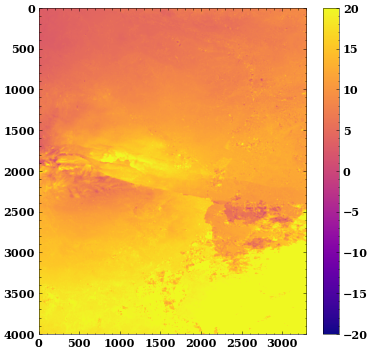

In [33]:
unw = np.fromfile(outfile1, dtype='float32').reshape((rows, cols))
plotting.plot_image(unw, cmap="plasma", vmin=-20, vmax=20, figsize=(6, 6));

# 2-Stage Unwrapping: basic version, and with SNAPHU reoptimization

Now we'll show two versions of unwrapping following the 2 stage approach for using extra-multilooked data as an ambiguity guide to unwrap high resolution data.

We'll divide this unwrapping process into 3 parts (the first two are the "two-stage" unwrapping from previous UAVSAR papers, e.g. Miller 2020)

1. Perform extra multilooking (often 3x3 beyond what you're desired resolution is) on a large interferogram, and unwrap with SNAPHU. This will run quickly.
2. Apply the integer ambiguity, solved for by SNAPHU on the low-res data, to the high-res interferogram
3. Use the output of step 2 into SNAPHU with the "-u" flag added to signal that we are starting with at already-mostly-unwrapped version

The 3rd step is an extra step I wanted to try, as I saw this option baked into SNAPHU: the use of the `-u` option in SNAPHU can reoptimize a mostly-unwrapped input file: 

>  −u: Assume that the input file is unwrapped rather than wrapped. The algorithm makes iterative improvements to this solution instead of using an initialization routine.




 	


## Stage 1: extra multilooking and unwrap

In [19]:
def take_looks(arr, row_looks, col_looks, separate_complex=False, **kwargs):
    """Downsample a numpy matrix by summing blocks of (row_looks, col_looks)

    Cuts off values if the size isn't divisible by num looks

    NOTE: For complex data, looks on the magnitude are done separately
    from looks on the phase

    Args:
        arr (ndarray) 2D array of an image
        row_looks (int) the reduction rate in row direction
        col_looks (int) the reduction rate in col direction
        separate_complex (bool): take looks on magnitude and phase separately
            Better to preserve the look of the magnitude

    Returns:
        ndarray, size = ceil(rows / row_looks, cols / col_looks)
    """
    if row_looks == 1 and col_looks == 1:
        return arr
    if np.iscomplexobj(arr) and separate_complex:
        mag_looked = take_looks(np.abs(arr), row_looks, col_looks)
        phase_looked = take_looks(np.angle(arr), row_looks, col_looks)
        return mag_looked * np.exp(1j * phase_looked)

    rows, cols = arr.shape
    new_rows = rows // row_looks
    new_cols = cols // col_looks

    row_cutoff = rows % row_looks
    col_cutoff = cols % col_looks

    if row_cutoff != 0:
        arr = arr[:-row_cutoff, :]
    if col_cutoff != 0:
        arr = arr[:, :-col_cutoff]
    # For taking the mean, treat integers as floats
    if np.issubdtype(arr.dtype, np.integer):
        arr = arr.astype("float")

    return np.mean(arr.reshape(new_rows, row_looks, new_cols, col_looks), axis=(3, 1))

In [20]:
looks = (4, 4)
ifg_extra_looked = take_looks(ifg_cropped, *looks)
cor_extra_looked = take_looks(cor_cropped, *looks)
looked_shape = ifg_extra_looked.shape
print(looked_shape)


ifg_extra_looked_filename = "cropped_{}x{}_looked_".format(*looks) + ifg_filename
cor_extra_looked_filename = "cropped_{}x{}_looked_".format(*looks) + cor_filename
print("Saving looked ifg to", ifg_extra_looked_filename)
ifg_extra_looked.tofile(ifg_extra_looked_filename)
print("Saving looked cor to", cor_extra_looked_filename)
cor_extra_looked.tofile(cor_extra_looked_filename)

(1000, 825)
Saving looked ifg to cropped_4x4_looked_SanAnd_23511_14068-001_14128-002_0092d_s01_L090HH_02.int
Saving looked cor to cropped_4x4_looked_SanAnd_23511_14068-001_14128-002_0092d_s01_L090HH_02.cor


In [21]:
outfile_looked = ifg_extra_looked_filename.replace(".int", ".unw")

ntilerow, ntilecol = 2, 2
nproc = ntilerow * ntilecol
overlap = 400

conf_looked = "snaphu_looked.conf"
with open(conf_looked, "w") as f:
    f.write(
        conf_template.format(
            infile=ifg_extra_looked_filename,
            corfile=cor_extra_looked_filename,
            width=looked_shape[1],
            outfile=outfile_looked,
            informat="COMPLEX_DATA",
            outformat="FLOAT_DATA",
            overlap=overlap,
            ntilerow=ntilerow,
            ntilecol=ntilecol,
            nproc=nproc,
        )
    )

In [22]:
%%time
print("Outputting looked unwrapped phase to", outfile_looked)
cmd = "snaphu -f " + conf_looked
print(cmd)
subprocess.call(cmd, shell=True)

Outputting looked unwrapped phase to cropped_4x4_looked_SanAnd_23511_14068-001_14128-002_0092d_s01_L090HH_02.unw
snaphu -f snaphu_looked.conf
CPU times: user 3.01 ms, sys: 23.1 ms, total: 26.2 ms
Wall time: 14 s


0

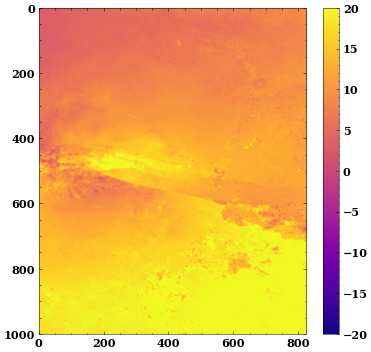

In [24]:
unw_looked = np.fromfile(outfile_looked, dtype='float32').reshape(looked_shape)
plotting.plot_image(unw_looked, cmap="plasma", vmin=-20, vmax=20, figsize=(6, 6));

## Stage 2: apply the phase mask to transfer the 2pi ambiguity to the high-res data

Although the papers using UAVSAR data which use the 2-stage unwrapping procedure (Sharma 2016, Bekaert 2019, Miller 2020) have more logic to mask/interpolate the multilooked interferograms, the basic logic for the unwrapping is captured in this function:

In [ ]:
def apply_phasemask(unw_low, intf_high):
    """Apply the integer phase ambiguity in the unwrapped phase array `unw_low` 
    to the phase in the wrapped, complex array `intf_high`. 
    
    You should use this routine to apply an unwrapping solution obtained on 
    low resolution data back to a higher resolution version of the same data.

    If the `unw_low` has been multilooked 3x3 extra times beyond `intf_high`, then
    each pixel in `unw_low` will be used for a 3x3 square of high-res data.
    
    Returns:
        ndarray, size = `intf_high.shape`. Unwrapped version of the high resolution data.
    """
    from skimage.transform import resize
    # Resize the low res data to the same size as high-res. 
    # mode="constant" uses nearest-neighbor interpolation
    unw_high = resize(unw_low, intf_high.shape, mode="constant", anti_aliasing=False)

    # Make sure we're working with phase, not complex numbers
    highres = np.angle(intf_high) if np.iscomplexobj(intf_high) else intf_high

    # Find the total radians between the wrapped an unwrapped 
    dx = highres - unw_high
    # convert the to nearest number of whol cycles, then back to ambiguity in radians
    whole_cycles = np.around(dx / (2 * np.pi))
    ambig = (2 * np.pi) * whole_cycles
    highres_unw = highres - ambig
    
    return highres_unw
    # To return the unwrapped with both amplitude an phase (to save as a band-interleaved file)
    # return np.stack((np.abs(intf_high), highres), axis=0)


(Note that this works on my workstation, which has ~64 GB of RAM. For very large interferograms/on smaller machines, there will have to be more patch-loading logic to work on smaller pieces)

In [36]:
unw_2stage = apply_phasemask(unw_looked, ifg_cropped)

# Save as a float32 file
outfile_2stage = "2stage_" + outfile_looked
unw_2stage.tofile(outfile_2stage)

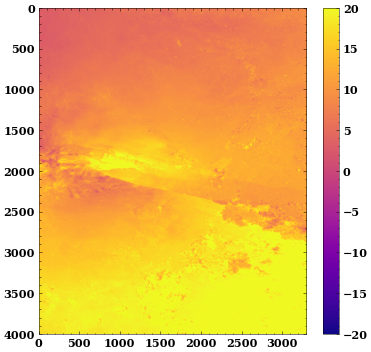

In [37]:
#reload to verify it worked correctly:
unw_2stage = np.fromfile(outfile_2stage, dtype='float32').reshape((rows, cols))
plotting.plot_image(unw_2stage, cmap="plasma", vmin=-20, vmax=20, figsize=(6, 6));

Now we have the full resolution data, unwrapped using the lower-res data

## Stage 3: rerun SNAPHU on stage 2 output with -u flag


Instead of the "-u" command line flag, we'll add it in the configuration file.

Relevant configuration file parts:
```
# Unwrapped-input mode (TRUE or FALSE)
UNWRAPPED_IN	TRUE

# Unwrapped input file format
# Allowable formats:
#   ALT_LINE_DATA       (interferogram magnitude in channel 1, 
#                        unwrapped phase in radians in channel 2; default)
#   ALT_SAMPLE_DATA     (interferogram magnitude in channel 1, 
#                        unwrapped phase in radians in channel 2)
#   FLOAT_DATA          (unwrapped phase in radians)
#
UNWRAPPEDINFILEFORMAT	FLOAT_DATA 
```
Using `FLOAT_DATA` for `UNWRAPPEDINFILEFORMAT` since that is the default of the UAVSAR 2-stage script.

In [38]:
outfile_reopt = "repot_" + outfile_2stage

ntilerow, ntilecol = 3, 3
nproc = ntilerow * ntilecol
overlap = 400

conf_str = conf_template.format(
    infile=outfile_2stage,
    corfile=cor_cropped_filename,
    width=cols,
    outfile=outfile_reopt,
    informat="FLOAT_DATA",
    outformat="FLOAT_DATA",
    overlap=overlap,
    ntilerow=ntilerow,
    ntilecol=ntilecol,
    nproc=nproc,
)

# Add the extra configution options for -u mode
conf_str += """
UNWRAPPED_IN    TRUE
UNWRAPPEDINFILEFORMAT    FLOAT_DATA
"""
conf_repot = "snaphu_repot.conf"
with open(conf_repot, "w") as f:
    f.write(conf_str)


In [39]:
%%time
print("Outputting reoptimized output to", outfile_reopt)
cmd = "snaphu -f " + conf_repot
print(cmd)
subprocess.call(cmd, shell=True)

Outputting looked unwrapped phase to 2stage_cropped_4x4_looked_SanAnd_23511_14068-001_14128-002_0092d_s01_L090HH_02.unw
snaphu -f snaphu_repot.conf
CPU times: user 21.7 ms, sys: 89.7 ms, total: 111 ms
Wall time: 3min 29s


0

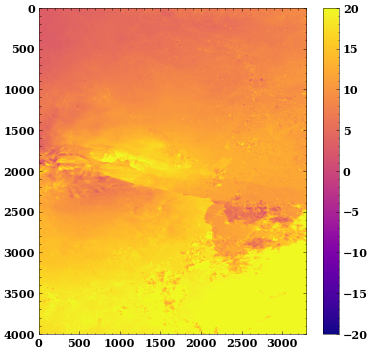

In [43]:
unw_reopt = np.fromfile(outfile_reopt, dtype='float32').reshape((rows, cols))
plotting.plot_image(unw_reopt, cmap="plasma", vmin=-20, vmax=20, figsize=(6, 6));


## Analysis: Checking differences between stage 2 and 3

The initial unwrapping is pretty close to the final product, but there are small pockets of differences.

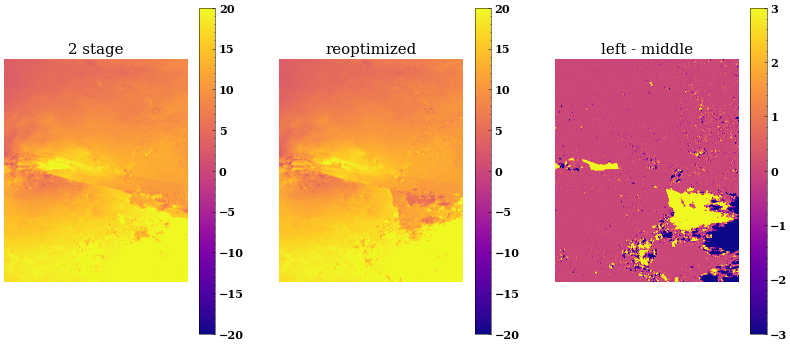

(<Figure size 1008x432 with 6 Axes>,
 array([<AxesSubplot:title={'center':'2 stage'}>,
        <AxesSubplot:title={'center':'reoptimized'}>,
        <AxesSubplot:title={'center':'left - middle'}>], dtype=object))

In [22]:
plotting.plot_img_diff(
    arrays=(unw_2stage, unw_reopt),
    cmap="plasma",
    vm=20,
    vdiff=3,
    figsize=(14, 6),
    titles=("2 stage", "reoptimized")
);

The area to the bottom right is over water, so it will get masked out in the final product anyway.

There is a difference near the fault which appears to have been improved by the extra rerun:

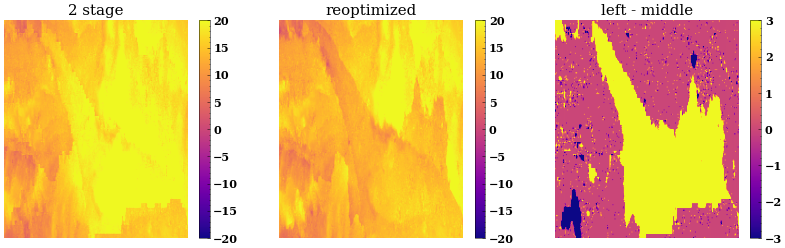

In [57]:
zoom = slice(1800, 2000), slice(300, 1200)
fig, axes = plotting.plot_img_diff(
    arrays=(unw_2stage[zoom], unw_reopt[zoom]),
    cmap="plasma",
    vm=20,
    vdiff=3,
    figsize=(14, 4),
    titles=("2 stage", "reoptimized"),
    aspect="auto",
)

To see this more clearly, we'll compare both to the original interferogram phase, and rewrap each unwrapped version back into 3 pi radians:

In [82]:
def compare_orig_ifg(ifg, unw1, unw2, zoom=None, cmap="dismph", figsize=(16, 4)):
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=figsize)
    vmax, vmin = np.pi, -np.pi
    intp = "nearest"

    ax = axes[0]
    axim = ax.imshow(
        np.angle(ifg)[zoom], cmap=cmap, vmax=vmax, vmin=vmin, interpolation=intp
    )
    ax.set_title("Original ifg")

    # Rewrap the unwrapped for easiest visual of differences
    vmax, vmin = 3 * np.pi, 0
    ax = axes[1]
    axim = ax.imshow(
        np.mod(unw1[zoom], 3 * np.pi),
        cmap=cmap,
        vmax=vmax,
        vmin=vmin,
        interpolation=intp,
    )
    ax.set_title("2 Stage")

    ax = axes[2]
    axim = ax.imshow(
        np.mod(unw2[zoom], 3 * np.pi),
        cmap=cmap,
        vmax=vmax,
        vmin=vmin,
        interpolation=intp,
    )
    ax.set_title("Reoptimized")

    for ax in axes:
        ax.set_axis_off()
        ax.set_aspect("auto")

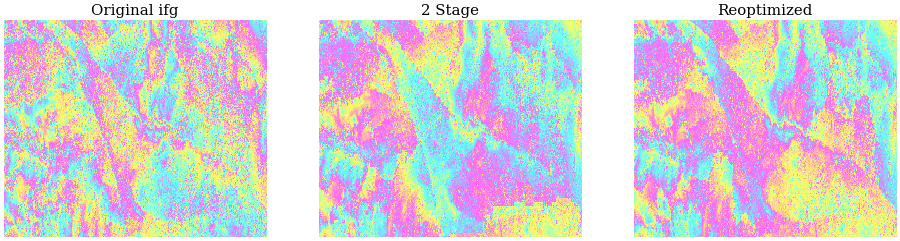

In [79]:
zoom = slice(1800, 2000), slice(300, 1200)
compare_orig_ifg(ifg_cropped, unw_2stage, unw_reopt, zoom=zoom)

While it's difficult to determin which is better everywhere across the fault, the area in the bottom right has several clear artifacts in the middle "2 stage" version, which are fixed in the reoptimization.

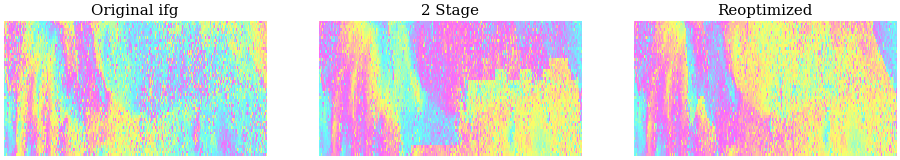

In [83]:
zoom = slice(1950, 2000), slice(500, 1200)
compare_orig_ifg(ifg_cropped, unw_2stage, unw_reopt, zoom=zoom, figsize=(16, 2.5))

# Appendix

## Tiling artifacts

In my attempt to show what happens when you have too small of a tiling overlap, I couldn't get snaphu to mess up and produce tiling artifacts. Oh well.

In [9]:
outfile2 = ifg_cropped_filename.replace(".int", "_tiled_badly.unw")

conf_bad = "snaphu_tiling_bad_overlap.conf"
with open(conf_bad, "w") as f:
    f.write(
        conf_template.format(
            infile=ifg_cropped_filename,
            corfile=cor_cropped_filename,
            width=cols,
            outfile=outfile2,
            informat="COMPLEX_DATA",
            outformat="FLOAT_DATA",
            overlap=2,
            ntilerow=4,
            ntilecol=3,
            nproc=12,
        )
    )

In [15]:
%%time
print("Outputting unwrapped phase to", outfile1)
cmd = "snaphu -f " + conf_bad
print(cmd)
subprocess.call(cmd, shell=True)

Outputting unwrapped phase to cropped_SanAnd_23511_14068-001_14128-002_0092d_s01_L090HH_02_tiled.unw
snaphu -f snaphu_tiling_bad_overlap.conf
CPU times: user 9.32 ms, sys: 147 ms, total: 156 ms
Wall time: 1min 9s


0

SNAPHU is pretty good at not having artifacts

(<Figure size 432x432 with 2 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x7f4de9f22c10>)

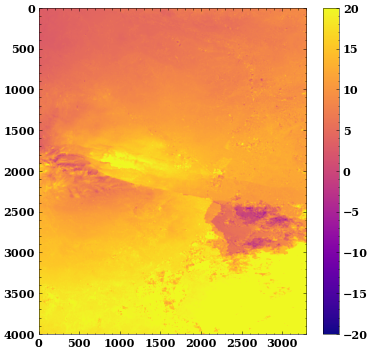

In [16]:
unw_bad = np.fromfile(outfile2, dtype='float32').reshape((rows, cols))
plotting.plot_image(unw_bad, cmap="plasma", vmin=-20, vmax=20, figsize=(6, 6));